In [ ]:
!pip install torch 
!pip install torchvision
!pip install torchsummary
!pip install wandb 


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import datasets, transforms
import os
import wandb
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)



Device: cuda


In [2]:
data_dir = os.path.join('nature_12K', 'inaturalist_12K')
train_dir = os.path.join(data_dir, 'train')
best_model_path = "best_models"
os.makedirs(best_model_path, exist_ok=True)

print("Data directory:", data_dir)

Data directory: nature_12K\inaturalist_12K


In [3]:

def get_data_loaders(config):
    # Constants
    BATCH_SIZE = config.get("batch_size", 64)
    IMAGE_SIZE = 224
    

    # Augmentation logic
    if config.get("augment", False):
        print("Applying full data augmentation")
        transform_train = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
    else:
        print("Minimal preprocessing, no augmentation")
        transform_train = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])

    transform_val = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    # Load full training dataset
    full_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
    targets = np.array(full_dataset.targets)

    # Stratified split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(np.zeros(len(targets)), targets))

    # Subsets with respective transforms
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset = Subset(datasets.ImageFolder(root=train_dir, transform=transform_val), val_idx)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Info
    print(f"Total images: {len(full_dataset)}")
    print(f"Training set: {len(train_dataset)} images")
    print(f"Validation set: {len(val_dataset)} images")
    print(f"Number of classes: {len(full_dataset.classes)}")

    return train_loader, val_loader #, len(full_dataset.classes)


In [4]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_filters, activation_fn, kernel_size, dense_neurons, num_classes=1010, dropout_rate=0.2, batch_norm=False):
        super().__init__()

        act_fn = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'silu': nn.SiLU(),
            'mish': nn.Mish()
        }[activation_fn]

        layers = []
        in_channels = 3

        for nf in num_filters:
            layers.append(nn.Conv2d(in_channels, nf, kernel_size=kernel_size, padding=kernel_size//2))
            if batch_norm:
                layers.append(nn.BatchNorm2d(nf))
            layers.append(act_fn)
            layers.append(nn.MaxPool2d(kernel_size=2))
            in_channels = nf

        self.feature_extractor = nn.Sequential(*layers)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(num_filters[-1] * 7 * 7, dense_neurons)
        self.output = nn.Linear(dense_neurons, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = self.output(x)
        return x


In [5]:
def compute_model_stats(m, k, n, input_size=(224, 224), num_layers=555, num_classes=1010):
    H, W = input_size
    computations = 0
    params = 0
    in_channels = 3

    for _ in range(num_layers):
        # Computations per conv: H*W * (in_channels * k^2)
        computations += H * W * (in_channels * k * k) * m
        # Parameters per conv: m * (in_channels * k^2 + 1 bias)
        params += m * (in_channels * k * k + 1)
        in_channels = m
        H, W = H // 2, W // 2  # Due to MaxPooling

    flattened = in_channels * H * W
    params += flattened * n + n  # Dense layer
    params += n * num_classes + num_classes  # Output layer
    computations += flattened * n + n + n * num_classes + num_classes

    return computations, params

# Example usage
m, k, n = 32, 3, 512
comp, param = compute_model_stats(m, k, n)
print(f"Total Computations: {comp:,}")
print(f"Total Parameters: {param:,}")


Total Computations: 197,953,010
Total Parameters: 5,642,930


In [6]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    return val_loss / total, correct / total


In [7]:
PROJECT_NAME = "da24m029-da6401-assignment2"  # Replace with your project name
ENTITY_NAME = "da24m029-indian-institute-of-technology-madras"  # Replace with your entity name

In [27]:
def sweep_train():
    wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME)
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Compute num_filters based on filter_organization
    num_layers = 5
    if config.filter_organization == "same":
        filters = [config.filters_base] * num_layers
    elif config.filter_organization == "double":
        filters = [config.filters_base * (2 ** i) for i in range(num_layers)]
    elif config.filter_organization == "half":
        # filters = [max(config.filters_base // (2 ** i), 1) for i in range(num_layers)]
        filters = [config.filters_base * (2 ** i) for i in range(num_layers)]
        filters = filters[::-1]  # Reverse the order
    else:
        raise ValueError(f"Unknown filter organization: {config.filter_organization}")

    wandb.run.name = (
        f"fbase_{config.filters_base}_"
        f"forg_{config.filter_organization}_"
        f"act_{config.activation}_"
        f"k_{config.kernel_size}_"
        f"drop_{config.dropout}_"
        f"bn_{config.batch_norm}_"
        f"lr_{config.lr:.5f}_"
        f"aug_{config.augment}_"
        f"ep_{config.epochs}_"
        f"bs_{config.batch_size}_"
        f"n_{config.dense_neurons}"
    )
    wandb.run.save()

    # DataLoader
    train_loader, val_loader = get_data_loaders(
        {
        "batch_size":config.batch_size,
        "augment":config.augment
        }
    )

    # Model
    model = FlexibleCNN(
        num_filters=filters,
        activation_fn=config.activation,
        kernel_size=config.kernel_size,
        dense_neurons=config.dense_neurons,
        dropout_rate=config.dropout,
        batch_norm=config.batch_norm
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0.0

    for epoch in range(config.epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        print(f"Epoch {epoch + 1}/{config.epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # torch.save(model.state_dict(), os.path.join(best_model_path, "partA.pth"))
            torch.save(model, os.path.join(best_model_path, "partA.pth"))
            wandb.save("best_model_A.pth")


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {"name": "val_accuracy", "goal": "maximize"},
    "parameters": {
        "filters_base": {"values": [3, 8, 16, 32, 64]},
        "filter_organization": {"values": ["same", "double", "half"]},
        "activation": {"values": ["relu", "gelu", "silu", "mish"]},
        "kernel_size": {"values": [3, 5]},
        "dense_neurons": {"values": [256, 512]},
        "batch_norm": {"values": [True, False]},
        "dropout": {"values": [0.2, 0.3]},
        "lr": {"distribution": "uniform", "min": 0.0001, "max": 0.01},
        "batch_size": {"values": [32, 64]},
        "augment": {"values": [True, False]},
        "epochs": {"values": [5, 10, 15]}
    }
}
sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME, entity=ENTITY_NAME)
wandb.agent(sweep_id, function=sweep_train, count=60)  # Adjust count as needed
wandb.finish()


# Q3 Best Model

In [13]:
# best_model = torch.load(os.path.join(best_model_path, "partA.pth"))
torch.serialization.add_safe_globals([FlexibleCNN])
best_model = torch.load(os.path.join(best_model_path, "partA.pth"), weights_only=False)

In [10]:


# Reuse best known hyperparameters from your sweep
best_config = {
    "num_filters": [8, 16, 32, 64, 128],     # Filter sizes in each conv layer
    "kernel_size": 3,                           # Convolution kernel size
    "activation": "silu",                       # Activation function
    "use_batchnorm": True,                      # BatchNorm after conv?
    "dropout": 0.3,                             # Dropout rate
    "dense_neurons": 256,                       # FC layer size before classifier
    "num_classes": 10,                        # Number of output classes
    "lr": 0.00107,                                 # Learning rate
    "batch_size": 64,                           # Just for tracking, if dynamic
    "augment": False,                            # If data augmentation is used
    "epochs": 10                                # Number of training epochs
}

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
# Instantiate model
best_model = FlexibleCNN(
    num_filters=best_config["num_filters"],
    kernel_size=best_config["kernel_size"],
    activation_fn=best_config["activation"],          
    batch_norm=best_config["use_batchnorm"],          
    dropout_rate=best_config["dropout"],              
    dense_neurons=best_config["dense_neurons"],
    num_classes=best_config["num_classes"]
).to(device)


# DataLoader
train_loader, val_loader = get_data_loaders(
        {
        "batch_size": best_config["batch_size"],
        "augment": best_config["augment"]

        }
    )
# Load or Train Model
try:
    # best_model = torch.load(os.path.join(best_model_path, "partA.pth"))
    torch.serialization.add_safe_globals([FlexibleCNN])
    best_model = torch.load(os.path.join(best_model_path, "partA.pth"), weights_only=False)
    print("Loaded best_model.pth")
except (FileNotFoundError, RuntimeError) as e:
    print("best_model.pth not found or incompatible. Training the model...")

    # Initialize wandb
    wandb.init(project=PROJECT_NAME, entity=ENTITY_NAME, name="retrained_best_model", config=best_config)

    # Optimizer & Loss
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_config["lr"])
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0.0
    for epoch in range(best_config["epochs"]):
        train_loss, train_acc = train_one_epoch(best_model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(best_model, val_loader, criterion, device)

        print(f"[Epoch {epoch+1}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Log metrics to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

    torch.save(best_model, os.path.join(best_model_path, "partA.pth"))
    
    print("Saved new best_model.pth")

    wandb.finish()

# Set to evaluation mode for testing/inference
best_model.eval()


Minimal preprocessing, no augmentation


Total images: 9999
Training set: 7999 images
Validation set: 2000 images
Number of classes: 10
best_model.pth not found or incompatible. Training the model...


wandb: Currently logged in as: da24m029 (da24m029-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 125/125 [01:57<00:00,  1.06it/s]


[Epoch 1] Train Acc: 0.1945 | Val Acc: 0.2490


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


[Epoch 2] Train Acc: 0.2707 | Val Acc: 0.2750


100%|██████████| 125/125 [01:01<00:00,  2.03it/s]


[Epoch 3] Train Acc: 0.2959 | Val Acc: 0.2935


100%|██████████| 125/125 [01:01<00:00,  2.04it/s]


[Epoch 4] Train Acc: 0.3138 | Val Acc: 0.3130


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


[Epoch 5] Train Acc: 0.3394 | Val Acc: 0.3050


100%|██████████| 125/125 [01:06<00:00,  1.87it/s]


[Epoch 6] Train Acc: 0.3418 | Val Acc: 0.3365


100%|██████████| 125/125 [01:02<00:00,  2.00it/s]


[Epoch 7] Train Acc: 0.3614 | Val Acc: 0.3385


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


[Epoch 8] Train Acc: 0.3749 | Val Acc: 0.3400


100%|██████████| 125/125 [01:01<00:00,  2.02it/s]


[Epoch 9] Train Acc: 0.3862 | Val Acc: 0.3560


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


[Epoch 10] Train Acc: 0.4049 | Val Acc: 0.3550
Saved new best_model.pth


FlexibleCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SiLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SiLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # match training image size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # match training normalization
])


test_dataset = datasets.ImageFolder(os.path.join(data_dir,'val'), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [12]:
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)

# Print it
print(f" Final Test Accuracy: {test_accuracy:.4f}")

# Log to wandb (if active)
if wandb.run is not None:
    wandb.log({"test_accuracy": test_accuracy})


100%|██████████| 32/32 [00:55<00:00,  1.73s/it]


 Final Test Accuracy: 0.3790


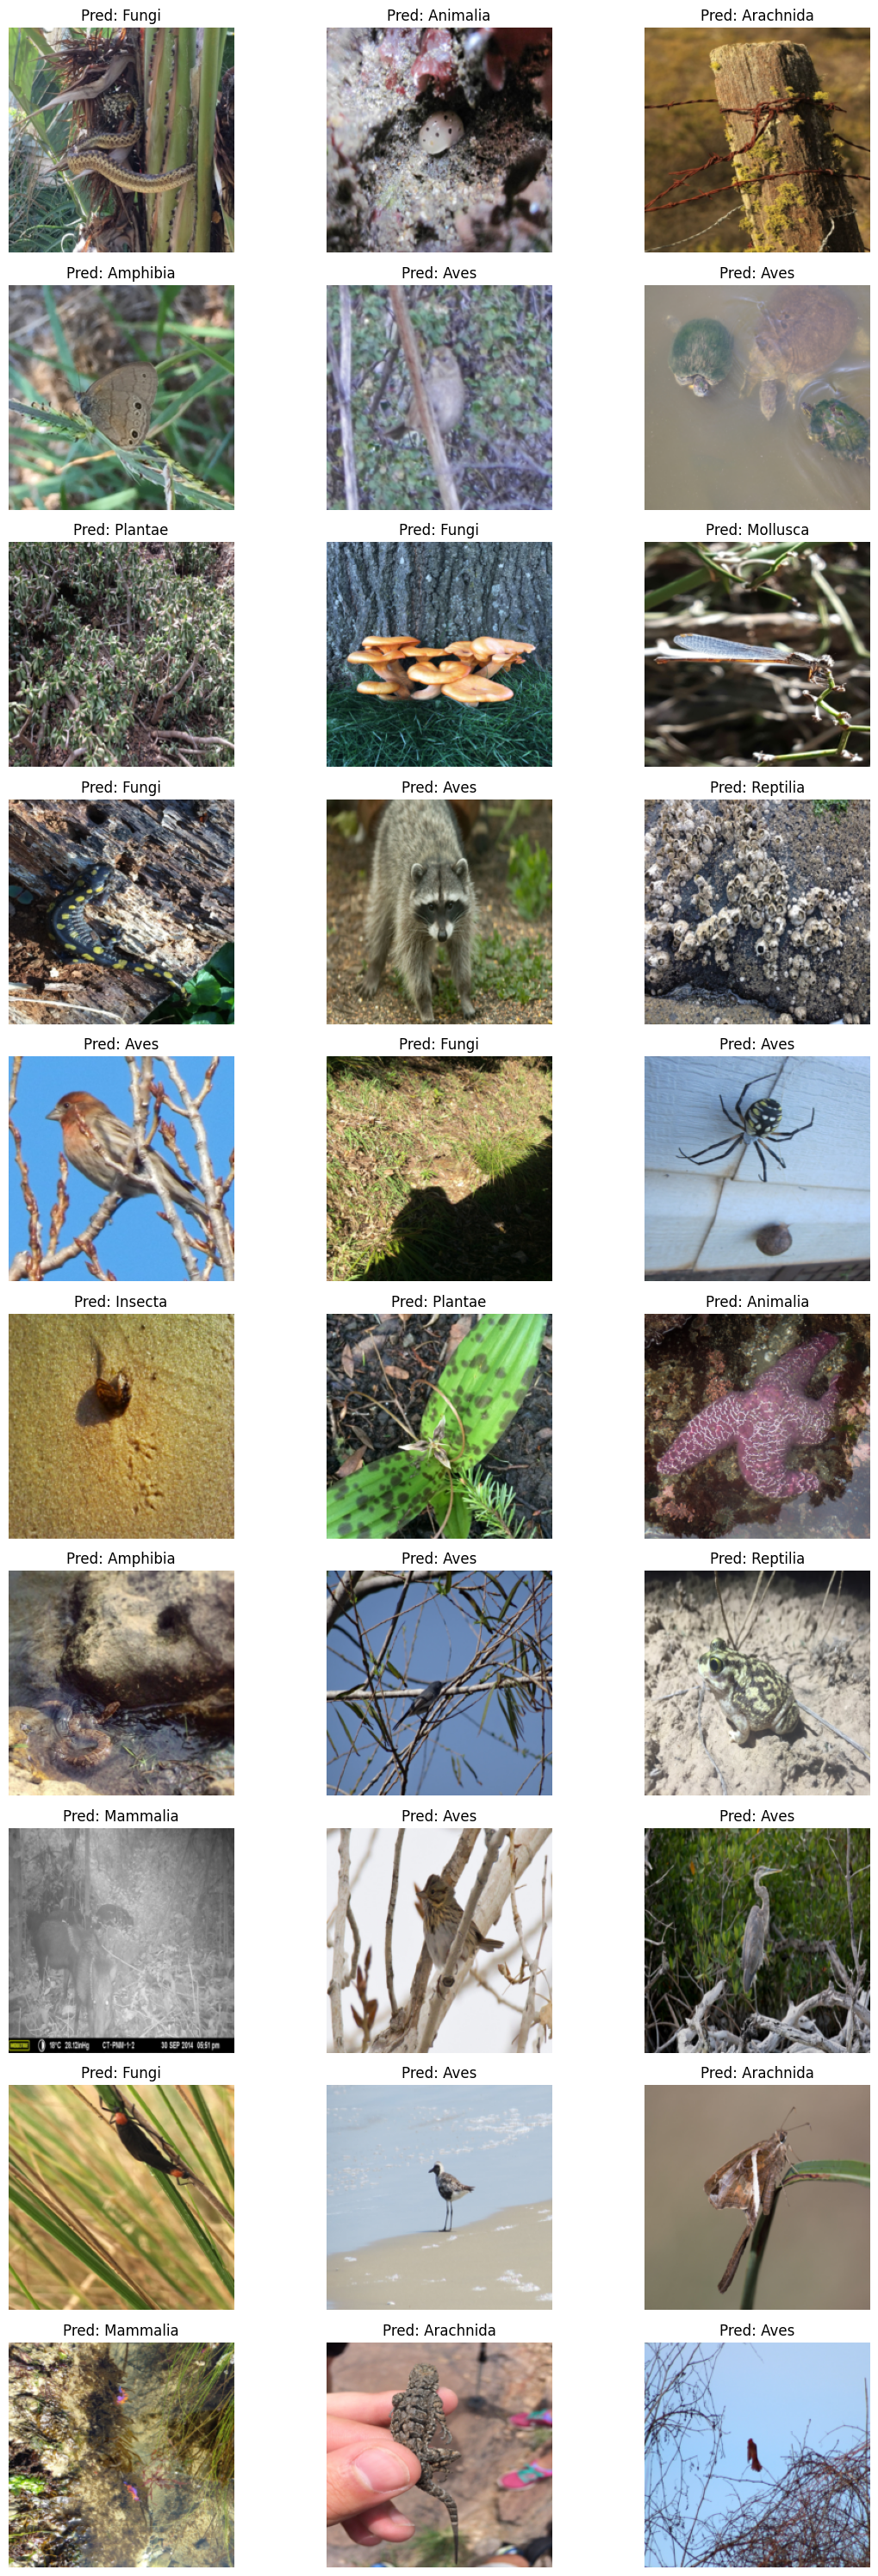

In [13]:
# Randomly pick 30 test images
indices = random.sample(range(len(test_dataset)), 30)
fig, axes = plt.subplots(10, 3, figsize=(12, 30))

for ax, idx in zip(axes.flatten(), indices):
    img, true_label = test_dataset[idx]
    model_input = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = best_model(model_input).argmax().item()

    # De-normalize for visualization
    img_np = img.permute(1, 2, 0).numpy()
    img_np = np.clip((img_np * 0.5) + 0.5, 0, 1)

    ax.imshow(img_np)
    ax.set_title(f"Pred: {test_dataset.classes[pred]}")
    ax.axis('off')

plt.tight_layout()
plt.savefig("test_predictions_grid.png")  # Save the plot

# Log to wandb
if wandb.run is not None:
    wandb.log({
        "Test Prediction Grid": wandb.Image("test_predictions_grid.png")
    })

plt.show()
